# Project 3: Web APIs & NLP

### By Alex Lau

## 1. Table of Contents

1. [Table of Contents](#1.-Table-of-Contents)
2. [Loading Libraries](#2.-Loading-Libraries)
3. [Load in Data](#3.-Load-in-Data)
4. [Exploratory Data Analysis (EDA)](#4.-Exploratory-Data-Analysis-(EDA))
5. [Data Cleaning](#5.-Data-Cleaning)
6. [Model Preperation (Preprocessing)](#6.-Model-Preparation-(Preprocessing))
7. [Modeling](#7.-Modeling)
    <br>7.1 [Baseline Model](#7.1-Baseline-Model)
    <br>7.2 [Count Vectorized Logistic Regression](#7.2-Count-Vectorized-Logistic-Regression)
    <br>7.3 [TF-IDF Vectorized Logistic Regression](#7.3-TFIDF-Vectorized-Logistic-Regression)
    <br>7.4 [Multinomial Naive Bayes Classifier](#7.4-Multinomial-Naive-Bayes-Classifier)
    <br>7.5 [Gaussian Naive Bayes Classifier](#7.5-Gaussian-Naive-Bayes-Classifier)
8. [Model Selection](#8.-Model-Selection)
9. [Model Evaluation](#9.-Model-Evaluation)
10. [Conclusions and Evaluation](#10.-Conclusions-and-Evaluation)

## 2. Loading Libraries & Data

In [2]:
# Import libaries
import pandas as pd
import numpy as np
import requests
import datetime as dt
import time
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

from string import ascii_uppercase
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from nltk import word_tokenize, ngrams
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.base import TransformerMixin

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## 3. Load in Data

In a separate notebook, we created a function to engage with the reddit website and pull the content based on subreddit topics that we fed in. We have requested content from the last 150 days to gather a large enough dataset to generate significant results. We also delayed each iteration by 2 seconds to ensure we did not overload the server. Finally, we combined API pulls for both subreddits 'cars' and 'teslamotors' into a single dataframe, which we are reading in below. 

In [3]:
combined_sub_queries = pd.read_csv('../Data/subreddit_data.csv')

## 4. Exploratory Data Analysis (EDA)

In [4]:
# getting the length of columns and rows
combined_sub_queries.shape

(3039, 10)

In [5]:
# Identifying the data types for all columns
combined_sub_queries.dtypes

Unnamed: 0       int64
title           object
selftext        object
subreddit       object
created_utc      int64
author          object
num_comments     int64
score            int64
is_self           bool
timestamp       object
dtype: object

In [6]:
# Viewing the first 5 rows
combined_sub_queries.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,0,Finally getting FSD HW3.0,I just called service center and asked for HW3...,teslamotors,1581119843,name_nt_important,0,1,True,2020-02-07
1,1,Questions regarding destination chargers,[removed],teslamotors,1581120818,lukethenoteable,0,1,True,2020-02-07
2,4,Is this normal for regen braking?,[removed],teslamotors,1581121537,Treesten,0,1,True,2020-02-07
3,5,Regen braking issue,[removed],teslamotors,1581121975,Treesten,0,1,True,2020-02-07
4,7,Please stop pasting your stupid ads for your T...,[I can't be the only one who is annoyed by thi...,teslamotors,1581124918,tesrella,198,1,True,2020-02-07


In [7]:
# Viewing the last 5 rows
combined_sub_queries.tail()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
3034,491,Abarth 595 esseesse/competizione,[removed],cars,1571048824,MakeMemesFuckBitches,2,1,True,2019-10-14
3035,495,Weekly - What Car Should I Buy Megathread,\n#**Weekly - What Car Should I Buy Megathread...,cars,1571051433,AutoModerator,467,40,True,2019-10-14
3036,496,Identifying shady mis-badged cars/vans when tr...,[removed],cars,1571051526,KDE_Fan,1,1,True,2019-10-14
3037,497,Car parts assistance needes,Currently I only know one website which suppli...,cars,1571052604,Papapene-bigpene,2,0,True,2019-10-14
3038,499,What's the point of heel toe downshift in dail...,What makes it different from: approaching corn...,cars,1571053396,Deg1935,120,40,True,2019-10-14


In [8]:
# Reviewing the statistics of the columns, only limited to 3 numeric columns
combined_sub_queries.describe()

,Unnamed: 0,created_utc,num_comments,score
count,3039.000000,3.039000e+03,3039.000000,3039.000000
mean,252.357025,1.576260e+09,19.358671,3.706482
std,144.598183,3.743054e+06,54.927408,33.728382
min,0.000000,1.570751e+09,0.000000,0.000000
25%,127.000000,1.573431e+09,0.000000,1.000000
50%,255.000000,1.576119e+09,2.000000,1.000000
75%,376.500000,1.578786e+09,13.000000,1.000000
max,499.000000,1.581621e+09,741.000000,1359.000000


There are missing self-text values.

In [9]:
# idenfifying missing values
combined_sub_queries.isnull().sum()

Unnamed: 0       0
title            0
selftext        44
subreddit        0
created_utc      0
author           0
num_comments     0
score            0
is_self          0
timestamp        0
dtype: int64

In [10]:
# Viewing the posts without self-texts
combined_sub_queries[combined_sub_queries['selftext']=='[removed]']

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
1,1,Questions regarding destination chargers,[removed],teslamotors,1581120818,lukethenoteable,0,1,True,2020-02-07
2,4,Is this normal for regen braking?,[removed],teslamotors,1581121537,Treesten,0,1,True,2020-02-07
3,5,Regen braking issue,[removed],teslamotors,1581121975,Treesten,0,1,True,2020-02-07
5,8,"Model 3: Any pothole popping with 19"" wheels?",[removed],teslamotors,1581126318,teshreve,0,1,True,2020-02-07
6,10,Does anyone know if the Model Y 20” induction ...,[removed],teslamotors,1581130033,chas828,0,1,True,2020-02-07
...,...,...,...,...,...,...,...,...,...,...
3031,488,Need accident/insurance advice,[removed],cars,1571046798,flexlex24,2,1,True,2019-10-14
3032,489,Does anyone like this style of alloy wheel/hub...,[removed],cars,1571047095,SubaruToyotaFan1986,1,1,True,2019-10-14
3033,490,Need some advice,[removed],cars,1571047886,flexlex24,2,1,True,2019-10-14
3034,491,Abarth 595 esseesse/competizione,[removed],cars,1571048824,MakeMemesFuckBitches,2,1,True,2019-10-14


1310 or over 44% of posts have had their self-texts removed and a small portion do not have any values populated in this column. We will be focusing on the titles columns instead.

In [11]:
# viewing documents where sefttext was removed.
combined_sub_queries.head(20)

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,0,Finally getting FSD HW3.0,I just called service center and asked for HW3...,teslamotors,1581119843,name_nt_important,0,1,True,2020-02-07
1,1,Questions regarding destination chargers,[removed],teslamotors,1581120818,lukethenoteable,0,1,True,2020-02-07
2,4,Is this normal for regen braking?,[removed],teslamotors,1581121537,Treesten,0,1,True,2020-02-07
3,5,Regen braking issue,[removed],teslamotors,1581121975,Treesten,0,1,True,2020-02-07
4,7,Please stop pasting your stupid ads for your T...,[I can't be the only one who is annoyed by thi...,teslamotors,1581124918,tesrella,198,1,True,2020-02-07
5,8,"Model 3: Any pothole popping with 19"" wheels?",[removed],teslamotors,1581126318,teshreve,0,1,True,2020-02-07
6,10,Does anyone know if the Model Y 20” induction ...,[removed],teslamotors,1581130033,chas828,0,1,True,2020-02-07
7,12,Hello r/teslamotors new owner with some questi...,[removed],teslamotors,1581132539,Tumpias,0,1,True,2020-02-07
8,14,I have gone from tesla being my dream car to z...,https://www.theverge.com/platform/amp/2020/2/6...,teslamotors,1581134437,Throwaway777mmm,27,1,True,2020-02-07
9,15,Quick question:how do you guys work on your cars?,[removed],teslamotors,1581136526,steve_buchemi,0,1,True,2020-02-07


In [12]:
combined_sub_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    3039 non-null   int64 
 1   title         3039 non-null   object
 2   selftext      2995 non-null   object
 3   subreddit     3039 non-null   object
 4   created_utc   3039 non-null   int64 
 5   author        3039 non-null   object
 6   num_comments  3039 non-null   int64 
 7   score         3039 non-null   int64 
 8   is_self       3039 non-null   bool  
 9   timestamp     3039 non-null   object
dtypes: bool(1), int64(4), object(5)
memory usage: 216.8+ KB


It seems people are slightly more engaging on subreddit 'teslamotors' given the higher mean number of comments. 

In [13]:
# identifying the mean values for each subreddit
combined_sub_queries.groupby('subreddit').mean()

,Unnamed: 0,created_utc,num_comments,score,is_self
subreddit,,,,,
cars,250.111909,1.576163e+09,17.910832,4.131059,True
teslamotors,255.099415,1.576379e+09,21.127193,3.187865,True


In [14]:
# function for displaying bar graph of frequent terms based on the subreddit
def frequent_terms(subreddit, ngrams):
    cv = CountVectorizer(stop_words = 'english', ngram_range=ngrams)
    cv.fit(combined_sub_queries.loc[combined_sub_queries['subreddit'] == subreddit,'title'])
    X_cv = cv.transform(combined_sub_queries.loc[combined_sub_queries['subreddit'] == subreddit,'title'])
    X_cv_df = pd.DataFrame(X_cv.todense(), columns=cv.get_feature_names())
    bar_graph = X_cv_df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')
    plt.title(f'Most Frequent Terms in "{subreddit}"', size = 16)
    plt.xlabel('Frequency', size = 15)
    plt.ylabel('Words', size = 15)
    return bar_graph

Top 20 titles from subreddit "cars" unsurprisingly contains the word "car" many times. We can also derive that the most popular car of discussion is Honda Civic, followed by Ford Mustang, Toyota Camry, Land Rover Range Rover, and Toyota Corolla. We can also see more interest in new cars as opposed to used cars.

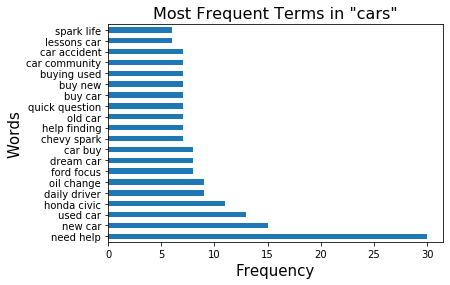

In [15]:
frequent_terms('cars', (2,2));

The most popular term in the "teslamotors" subreddit, "feature request", refers to over-the-air (OTA) software updates that Tesla sends out over time. These are mostly wish lists, and sometimes do come true when Tesla reviews feedback. Owners will frequently tweet Elon Musk, and he will respond! The 3rd most populate bigram is "smart summon" which refers to the feature of using phones to control the car to drive forward, backward, or even navigate to where you are in a parking lot. 
<br>We would expect low occurances of these terms in the 'cars' subreddit since most other auto manufacturers are not as software focused, and are lagging behind in this area. 
<br>We also see frequent occurances of the term "daily discussion" and "support thread" which we will need to take out since that is a general reddit term and not subreddit specific. 
<br>Given the high level of Tesla specific terms, we are confident in our ability to accuratly match titles to their respective subreddits.

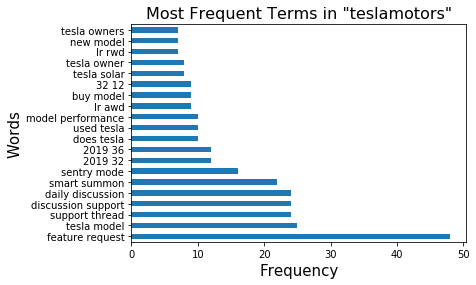

In [16]:
frequent_terms('teslamotors', (2,2));

In [17]:
# Split data up into X and y.
X = combined_sub_queries['title']
y = combined_sub_queries['subreddit'].map(lambda x: 1 if x == 'teslamotors' else 0)

cv = CountVectorizer(stop_words = 'english')
cv.fit(X)
X_cv = cv.transform(X)
words = pd.DataFrame(X_cv.todense(), columns=cv.get_feature_names())

# Let's look at the most frequently used words.
words.sum().sort_values(ascending=False).head(20)

car         560
tesla       368
model       308
cars        191
help        109
question    104
new         101
does         88
need         84
buy          78
vs           73
used         71
feature      65
2019         63
like         62
just         60
driving      59
best         56
drive        56
engine       52
dtype: int64

In [18]:
# checking the number of words
words.sum()

00          1
000        10
000usd      1
01          1
02          1
           ..
zr1         2
ดข          1
บเคล        1
อนไฟฟ       1
าขนาดเล     1
Length: 4657, dtype: int64

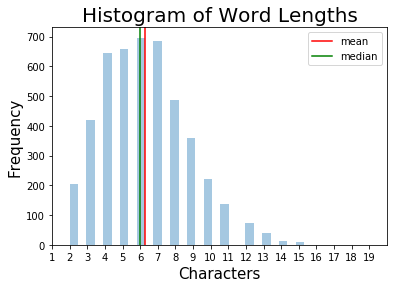

In [20]:
# Plot the character lengths of the words.
lengths_of_words = [len(each) for each in words.columns]
fig, ax = plt.subplots()
sns.distplot(lengths_of_words, ax=ax, kde = False)
plt.title('Histogram of Word Lengths', size = 20)
plt.axvline(np.mean(lengths_of_words), 0,350, color = 'red', label = 'mean')
plt.axvline(np.median(lengths_of_words), 0,350, color = 'green', label = 'median')
plt.ylabel('Frequency', size = 15)
plt.xlabel('Characters', size = 15)
ax.set_xlim(1,20)
ax.set_xticks(range(1,20))
plt.legend()
plt.show();

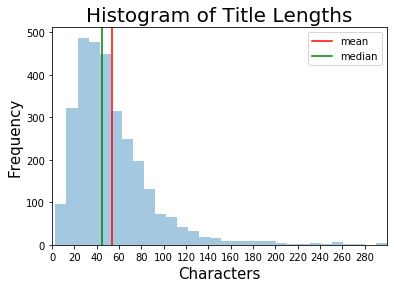

In [21]:
# Plot the character lengths of the titles.
lengths_of_posts = [len(each) for each in X]
fig, ax = plt.subplots()
sns.distplot(lengths_of_posts, kde = False, bins = 30) #kde = False
plt.title('Histogram of Title Lengths', size = 20)
plt.axvline(np.mean(lengths_of_posts), 0,350, color = 'red', label = 'mean')
plt.axvline(np.median(lengths_of_posts), 0,350, color = 'green', label = 'median')
plt.ylabel('Frequency', size = 15)
plt.xlabel('Characters', size = 15)
ax.set_xlim(1,300)
ax.set_xticks(range(0, 300, 20))
plt.legend()
plt.show();

In [22]:
# identifying the mean character lenght of titles
np.mean(lengths_of_posts)

53.53866403422178

In [23]:
# identifying the median character lenght of titles
np.median(lengths_of_posts)

45.0

In [24]:
# Checking the quantities of each class to confirm they are balanced
combined_sub_queries['subreddit'].value_counts()

cars           1671
teslamotors    1368
Name: subreddit, dtype: int64

## 5. Data Cleaning

In [25]:
combined_sub_queries

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,0,Finally getting FSD HW3.0,I just called service center and asked for HW3...,teslamotors,1581119843,name_nt_important,0,1,True,2020-02-07
1,1,Questions regarding destination chargers,[removed],teslamotors,1581120818,lukethenoteable,0,1,True,2020-02-07
2,4,Is this normal for regen braking?,[removed],teslamotors,1581121537,Treesten,0,1,True,2020-02-07
3,5,Regen braking issue,[removed],teslamotors,1581121975,Treesten,0,1,True,2020-02-07
4,7,Please stop pasting your stupid ads for your T...,[I can't be the only one who is annoyed by thi...,teslamotors,1581124918,tesrella,198,1,True,2020-02-07
...,...,...,...,...,...,...,...,...,...,...
3034,491,Abarth 595 esseesse/competizione,[removed],cars,1571048824,MakeMemesFuckBitches,2,1,True,2019-10-14
3035,495,Weekly - What Car Should I Buy Megathread,\n#**Weekly - What Car Should I Buy Megathread...,cars,1571051433,AutoModerator,467,40,True,2019-10-14
3036,496,Identifying shady mis-badged cars/vans when tr...,[removed],cars,1571051526,KDE_Fan,1,1,True,2019-10-14
3037,497,Car parts assistance needes,Currently I only know one website which suppli...,cars,1571052604,Papapene-bigpene,2,0,True,2019-10-14


In [26]:
# removing any potential duplicates
combined_sub_queries = combined_sub_queries.drop_duplicates()

In [27]:
# Viewing how balanced the data set is between the two classes
combined_sub_queries['subreddit'].value_counts()

cars           1671
teslamotors    1368
Name: subreddit, dtype: int64

We have setup stop words to remove the 'daily discussion' and 'support thread' in our model preparation section, which will run during our modeling section.

## 6. Model Preparation (Preprocessing)

In [28]:
# Setting up our X and y variables
X = combined_sub_queries['title']
y = combined_sub_queries['subreddit']

# train test splitting our data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [29]:
# setting up our classes to use later in our pipelines
# following code found on https://scikit-learn.org/stable/modules/feature_extraction.html
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
class StemTokenizer:
    def __init__(self):
        self.stemmer = PorterStemmer()
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc)]

# https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required/51127115#51127115
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [30]:
# setting up custom stop words
sw = ['daily discussion', 'support thread']

## 7. Modeling

### 7.1 Baseline Model

Our baseline is about 55%. This represents the majority class of subreddit 'cars' of our binary classification problem. We need to outperform this majority baseline score before we can claim usefulness from our models. 

In [31]:
baseline = y.value_counts(normalize = True).max()
baseline

0.5498519249753209

### 7.2 Count Vectorized Logistic Regression

Count Vectorizer is a transformer that tokenizes text by lowercasing and removing punctuation from words. It does not, however, convert the words to their root forms. We have introduced Porter Stemmer and WordNet Lemmatizer as a hyper-parameter in all of our models. Stemming may result in words that are not actual English words, but lemmatizing will root to actual English words. 
Logistic Regression is a linear where predictions are transformed using logistic function. There is a default penalty of L2, meaning this will automatically use the Ridge penalty and lower coefficients instead of removing them completely. We have included hyper parameters 'lbfgs', 'liblinear', and 'saga' and will have the model determine the best to use. 

In [32]:
# Instantiate pipeline.  
pipe_cv = Pipeline([
    ('cv', CountVectorizer(stop_words = sw)), 
    ('lr', LogisticRegression())
])

# Define grid of parameters to GridSearch over.
params_grid = {
    'cv__tokenizer': [LemmaTokenizer(), StemTokenizer()],
    'cv__max_features': [3950, 4000, 4050],
    'cv__stop_words': ['english'],
    'cv__ngram_range': [(1,7),(1,8)],
    'lr__solver': ['lbfgs', 'liblinear', 'saga']
}

# GridSearch over pipeline with given grid of parameters.
gs_cv = GridSearchCV(pipe_cv, params_grid, cv=5, scoring = 'accuracy')

# Fit model.
gs_cv.fit(X_train, y_train)

gs_cv.best_estimator_

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 's

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached whi

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 's

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 's

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached whi

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=3950, min_df=1,
                                 ngram_range=(1, 8), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.StemTokenizer object at 0x0000020F773B2D88>,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
           

In [33]:
gs_cv.best_params_

{'cv__max_features': 3950,
 'cv__ngram_range': (1, 8),
 'cv__stop_words': 'english',
 'cv__tokenizer': <__main__.StemTokenizer at 0x20f6b66e9c8>,
 'lr__solver': 'saga'}

In [34]:
# checking accuracy score
gs_cv_lr_accuracy = np.round(gs_cv.score(X_test, y_test), 4)
gs_cv_lr_accuracy

0.8855

### 7.3 TFIDF Vectorized Logistic Regression

Term frequency inverse document frequency (TF-IDF) Vectorizer is another tranformer that offers a more sophisticated approach as it builds on Count Vectorizer by increasing weights on words that are frequent in a document or row, but offsets this by decreasing weights on words that are frequent in the corpus, or the number of documents that contain the words in question. 

In [35]:
# Define Pipeline - TFIDF
pipe_tfidf = Pipeline(steps = [('tfidfvec', TfidfVectorizer(stop_words = sw)),     # first tuple is for first step: vectorizer
                         ('lr', LogisticRegression())        # second tuple is for second step: model
                        ])    

# Construct Grid Parameters
hyperparams_grid = {
                'tfidfvec__tokenizer': [LemmaTokenizer(), StemTokenizer()],
                'tfidfvec__max_features': [4050, 4100, 4150],
                'tfidfvec__ngram_range': [(1,4),(1,5),(1,6)],
                'tfidfvec__stop_words': ['english'],
                'lr__solver': ['liblinear', 'lbfgs', 'saga']
}

# Perform Grid Search
gs_tfidf = GridSearchCV(pipe_tfidf, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams_grid,
                 cv = 5,
                 scoring = 'accuracy')

gs_tfidf.fit(X_train, y_train)

# Get best estimator
gs_tfidf.best_estimator_

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

Pipeline(memory=None,
         steps=[('tfidfvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=4050,
                                 min_df=1, ngram_range=(1, 4), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_p...,
                                 tokenizer=<__main__.StemTokenizer object at 0x0000020F77C1C988>,
                                 use_idf=True, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

In [36]:
# checking accuracy score
gs_tfidf_lr_accuracy = np.round(gs_tfidf.score(X_test, y_test),4)
gs_tfidf_lr_accuracy

0.8868

### 7.4 Multinomial Naive Bayes Classifier

Mutlinomial Naive Bayes works when we have discrete data, building on Count Vectorizer using the counts of each word or token to classify and predict our y value.

In [37]:
# setup pipeline for Multinomial Naive Bayes
pipe_mnb = Pipeline([
     ('cvec', CountVectorizer(stop_words = sw)), 
     ('to_dense', DenseTransformer()), 
     ('mnb', MultinomialNB())
])

# Construct Grid Parameters
hyperparams_grid = {
                'cvec__tokenizer': [LemmaTokenizer(), StemTokenizer()],
                'cvec__max_features': [5000, 5500],
                'cvec__ngram_range': [(1,6),(1,7)],
                'cvec__stop_words': ['english'],
                'mnb__alpha': [0, 0.5, 1]
}

# Perform Grid Search
gs_mnb = GridSearchCV(pipe_mnb, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams_grid,
                 cv = 5,
                 scoring = 'accuracy')

gs_mnb.fit(X_train, y_train)

# Get best estimator
gs_mnb.best_estimator_

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in st

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=5000, min_df=1,
                                 ngram_range=(1, 6), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x0000020F77EF4408>,
                                 vocabulary=None)),
                ('to_dense',
                 <__main__.DenseTransformer object at 0x0000020F6B66E208>),
                ('mnb',
                 MultinomialNB(alpha=1, class_prior=None, fit_prior=True))],
         verbose=False)

In [38]:
gs_mnb.best_params_

{'cvec__max_features': 5000,
 'cvec__ngram_range': (1, 6),
 'cvec__stop_words': 'english',
 'cvec__tokenizer': <__main__.LemmaTokenizer at 0x20f772036c8>,
 'mnb__alpha': 1}

In [39]:
# checking accuracy score
gs_mnb_accuracy = np.round(gs_mnb.score(X_test, y_test), 4)
gs_mnb_accuracy

0.8868

### 7.5 Gaussian Naive Bayes Classifier####

Gaussian Naive Bayes is used in cases where our features are continuous, hence we will combine this with our TF-IDF Vectorizer. A Gaussian distributions is also called a normal distribtuion, providing a bell shaped curve symmetric about the mean of the feature values.

In [40]:
# setup pipeline for Multinomial Naive Bayes
pipe_gnb = Pipeline([
     ('tfidfvec', TfidfVectorizer(stop_words = sw)), 
     ('to_dense', DenseTransformer()), 
     ('gnb', GaussianNB())
])

# Construct Grid Parameters
hyperparams_grid = {
                'tfidfvec__tokenizer': [LemmaTokenizer(), StemTokenizer()],
                'tfidfvec__max_features': [5000, 5500, 6000],
                'tfidfvec__ngram_range': [(1,7), (1,8)],
                'tfidfvec__stop_words': ['english'],
                'gnb__var_smoothing': [0.7, 0.8, 0.9]
}

# Perform Grid Search
gs_gnb = GridSearchCV(pipe_gnb, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams_grid,
                 cv = 5,
                 scoring = 'accuracy')

gs_gnb.fit(X_train, y_train)

# Get best estimator
gs_gnb.best_estimator_

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feat

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] no

Pipeline(memory=None,
         steps=[('tfidfvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5500,
                                 min_df=1, ngram_range=(1, 7), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.StemTokenizer object at 0x0000020F77E57D88>,
                                 use_idf=True, vocabulary=None)),
                ('to_dense',
                 <__main__.DenseTransformer object at 0x0000020F77DA60C8>),
         

In [41]:
gs_gnb.best_params_

{'gnb__var_smoothing': 0.9,
 'tfidfvec__max_features': 5500,
 'tfidfvec__ngram_range': (1, 7),
 'tfidfvec__stop_words': 'english',
 'tfidfvec__tokenizer': <__main__.StemTokenizer at 0x20f778e3708>}

In [42]:
# checking accuracy score
gs_gnb_accuracy = np.round(gs_gnb.score(X_test, y_test), 4)
gs_gnb_accuracy

0.8737

In [43]:
# Evaluate predictions
print(f'Baseline accuracy score is : {np.round(baseline, 4)}.')
print()
print(f'Training accuracy score for our Count Vectorized Logistic Regression model is: {round(gs_cv.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our Count Vectorized Logistic Regression model is: {gs_cv_lr_accuracy}.')
print()
print(f'Training accuracy score for our TF-IDF Vectorized Logistic Regression model is: {round(gs_tfidf.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our TF-IDF Vectorized Logistic Regression model is: {gs_tfidf_lr_accuracy}.')
print()
print(f'Training accuracy score for our Multinomial Naive Bayes Classifier model is: {round(gs_mnb.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our Multinomial Naive Bayes Classifier model is: {gs_mnb_accuracy}.')
print()
print(f'Training accuracy score for our Gaussian Naive Bayes model is: {round(gs_gnb.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our Gaussian Naive Bayes model is: {gs_gnb_accuracy}.')

Baseline accuracy score is : 0.5499.

Training accuracy score for our Count Vectorized Logistic Regression model is: 0.9671.
Testing accuracy score for our Count Vectorized Logistic Regression model is: 0.8855.

Training accuracy score for our TF-IDF Vectorized Logistic Regression model is: 0.9495.
Testing accuracy score for our TF-IDF Vectorized Logistic Regression model is: 0.8868.

Training accuracy score for our Multinomial Naive Bayes Classifier model is: 0.9491.
Testing accuracy score for our Multinomial Naive Bayes Classifier model is: 0.8868.

Training accuracy score for our Gaussian Naive Bayes model is: 0.9469.
Testing accuracy score for our Gaussian Naive Bayes model is: 0.8737.


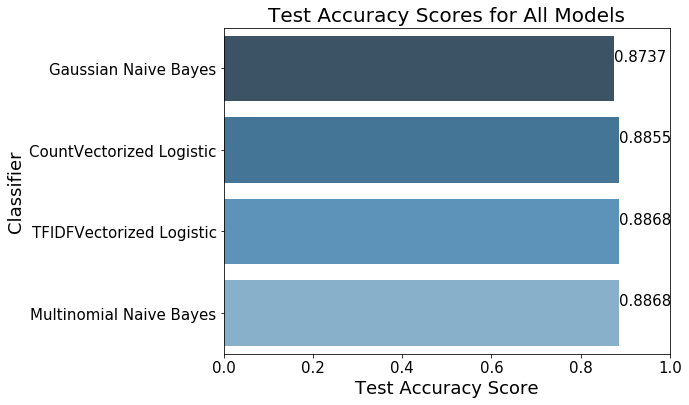

In [45]:
# initialize list of lists 
scores_list = [['CountVectorized Logistic', gs_cv_lr_accuracy], ['TFIDFVectorized Logistic', gs_tfidf_lr_accuracy], 
        ['Multinomial Naive Bayes', gs_mnb_accuracy], ['Gaussian Naive Bayes', gs_gnb_accuracy]]
  
# Create the pandas DataFrame 
scores_df = pd.DataFrame(scores_list, columns = ['Classifier', 'Test Accuracy Score']).sort_values('Test Accuracy Score')
# scores_df.sort_values(scores_df, ascending = False)

plt.figure(figsize = (8, 6))
ax = sns.barplot(x="Test Accuracy Score", y='Classifier', data=scores_df, palette = 'Blues_d')
plt.title(f'Test Accuracy Scores for All Models', size = 20)
plt.xlabel('Test Accuracy Score', size = 18)
plt.xticks(ticks = [0, 0.2, 0.4, 0.6, 0.8, 1], size = 15)
plt.yticks(size = 15)
plt.ylabel('Classifier', size = 18)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), i.get_y()+.31, \
            str(round((i.get_width()), 4)), fontsize=15, color='black')

## 8. Model Selection

Our best model in this iteration appears to be the TFIDF Vectorized Logistic Regression Model with an testing accuracy score of 88.68%, so we will select this to evaluate. This is 32 points above our baseline of 54.99%, or over 61% increase. We ran multiple iterations of our models and found that as titles of posts changed over time, our winning model would switch between TFIDF Vectorized Logistic regression and Multinomial Naive Bayes, but we never had an instance of the Gaussian Naive Bayes scoring highest. 

## 9. Model Evaluation

Below we are getting our best model, the 2nd value of our grid search from TFIDF Vectorized Logistic Regression model, and our best transformer, the 1st value. This will allow us to call dot(.) attributes and methods to eventually pull our coefficients, which will help us identify the most useful words for our model to predict the subreddit 'teslamotors'. 

In [46]:
best_model = gs_tfidf.best_estimator_[1]
best_transformer = gs_tfidf.best_estimator_[0]

In [47]:
features = best_transformer.get_feature_names()

In [48]:
coefs = best_model.coef_[0]

In [49]:
coef_df = pd.DataFrame({
    'feature':features,
    'coef': np.round(coefs, 2),
    'exp_coef': np.round(np.exp(coefs), 2)
})

The exp_coef below represents the odds that a title is classified as under subreddit 'teslamotors' given the word in the feature column exists in the document. It is not surprising that given a document contains the word "tesla" it is 1542 times as likely to be classified under 'teslamotors'. Terms beyond the obvious make and model include supercharge: a tesla coined term for charging stations with the ability to deliver electricity at extremely fast rates, autopilot: a driver assistance safety feature with automatic emergency braking, full-self driving (fsd): an autonomous driving feature. 

In [50]:
coef_df.sort_values(by = 'coef', ascending = False).head(20)

,feature,coef,exp_coef
3494,tesla,7.34,1542.01
2438,model,4.24,69.36
2439,model 3,3.20,24.53
374,3,2.68,14.58
1343,cybertruck,2.56,12.94
3414,supercharg,2.38,10.80
1828,fsd,2.33,10.24
3756,updat,2.19,8.95
1148,charg,2.15,8.59
770,autopilot,2.09,8.05


Below we have mapped a confusion matrix of the actual subreddit vs our predictions. We were better at accurately predicting titles that belonged in the cars subreddit than teslamotors. We were 94 % accurate with our predictions from actual subreddit 'cars', but only 82% accurate with our predictions from actual subreddit 'teslamotors'. This means there are still normal car terms used in subreddit 'teslamotors' that our model was unable to differentiate between the two, but this is expected. 

In [51]:
y_pred = gs_cv.predict(X_test)

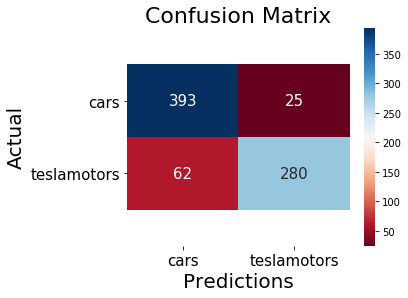

In [52]:
confm = confusion_matrix(y_test, y_pred)
columns = ['cars', 'teslamotors'] # need to fix this
df_cm = pd.DataFrame(confm, index=columns, columns=columns)
# sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.figure(figsize = (5, 4))
plt.title('Confusion Matrix', size = 22)
sns.heatmap(df_cm, annot=True, fmt = 'd', annot_kws={"size": 15}, cmap = 'RdBu')
plt.ylabel('Actual', size = 20)
plt.xlabel('Predictions', size = 20)
plt.yticks(rotation = 0, size = 15)
plt.xticks(size = 15)

# shoutout to SalMac86 on https://github.com/mwaskom/seaborn/issues/1773
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

## add xlabel and ylabel for predicted vs actual

In [53]:
# confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [54]:
# additional metrics
print('Accuracy:',  round((tp + tn) / (tp+fp+tn+fn), 4))
print('Recall/Sensitivity:', round((tp) / (tp+fn), 4))
print('Specificity:', round((tn) / (tn+fp), 4))
print('Precision:', round((tp) / (tp+fp), 4))

Accuracy: 0.8855
Recall/Sensitivity: 0.8187
Specificity: 0.9402
Precision: 0.918


## 10. Conclusions and Evaluation

All of our models were more successful than the baseline in classifying the subreddit, but our TFIDF Vectorized Logistic Model outperformed the rest with an testing accuracy score of 88.68% and training score of 94.95%. We are successful in building a model that can reasonably classify a title of a reddit post to belonging to subreddit 'teslamotors' or 'cars'. We were also successfull in identifying key words beyond the make and model that hold significance, such as autopilot, supercharger, and fsd for full self driving. Tesla spends $0 on advertising, so it is not surprising if the population is not familiar with these features in relation to vehicles. If we can educate the public on new technologies that exist on Tesla vehicles, specifically context behind the highest non-make and model coefficients of our model from subreddit 'teslamotors', we can potentially reduce the dependency on gas, slow down global warming and pollution, and save some lives with autopilot.